In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection,
)
import seaborn as sns 
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load your dataset (replace with your dataset)
data = pd.read_csv('../Data/dataset_1.csv')
X = data.drop(labels=['target'], axis=1)
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
    # ('correlation', SmartCorrelatedSelection(selection_method='variance')),
])

pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
X_train.shape, X_test.shape

((40000, 157), (10000, 157))

In [3]:
selected_features = X_train.columns
xgb_model = XGBClassifier(booster='gbtree',objective='binary:logistic', random_state=44, n_jobs=-1)
xgb_model.fit(X_train[selected_features], y_train)

auc_train = roc_auc_score(y_train, xgb_model.predict_proba(X_train[selected_features])[:,1])
auc_test = roc_auc_score(y_test, xgb_model.predict_proba(X_test[selected_features])[:,1])
print(f"AUROC (X_train) with selected features: {auc_train:.4f}")
print(f"AUROC (X_test) with selected features: {auc_test:.4f}")

AUROC (X_train) with selected features: 0.9652
AUROC (X_test) with selected features: 0.8294


In [4]:
feature_dict = dict(zip(X_train.columns, xgb_model.feature_importances_))
df_features = pd.DataFrame.from_dict(feature_dict, orient='index', columns=['Importance'])
df_features = df_features.sort_values(by='Importance', ascending=False)
selected_features = df_features.index[:20].tolist()
df_features.head()

,Importance
var_35,0.048367
var_168,0.031868
var_110,0.030369
var_105,0.020743
var_107,0.017387


In [5]:
xgb_model = XGBClassifier(booster='gbtree',objective='binary:logistic', random_state=44, n_jobs=-1)
xgb_model.fit(X_train[selected_features], y_train)

auc_train = roc_auc_score(y_train, xgb_model.predict_proba(X_train[selected_features])[:,1])
auc_test = roc_auc_score(y_test, xgb_model.predict_proba(X_test[selected_features])[:,1])
print(f"AUROC (X_train) with selected features: {auc_train:.4f}")
print(f"AUROC (X_test) with selected features: {auc_test:.4f}")

AUROC (X_train) with selected features: 0.9376
AUROC (X_test) with selected features: 0.8112


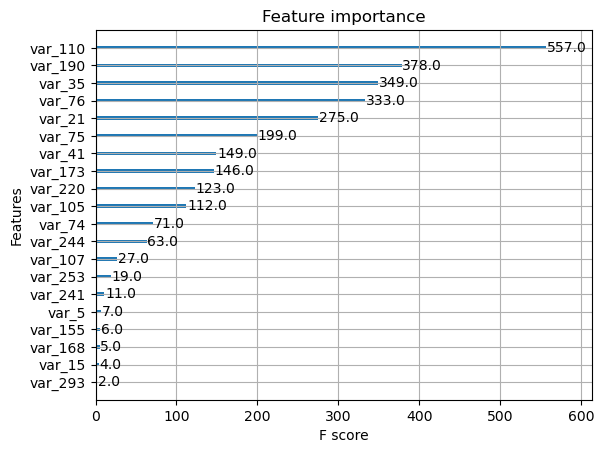

In [6]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(xgb_model)
plt.show()

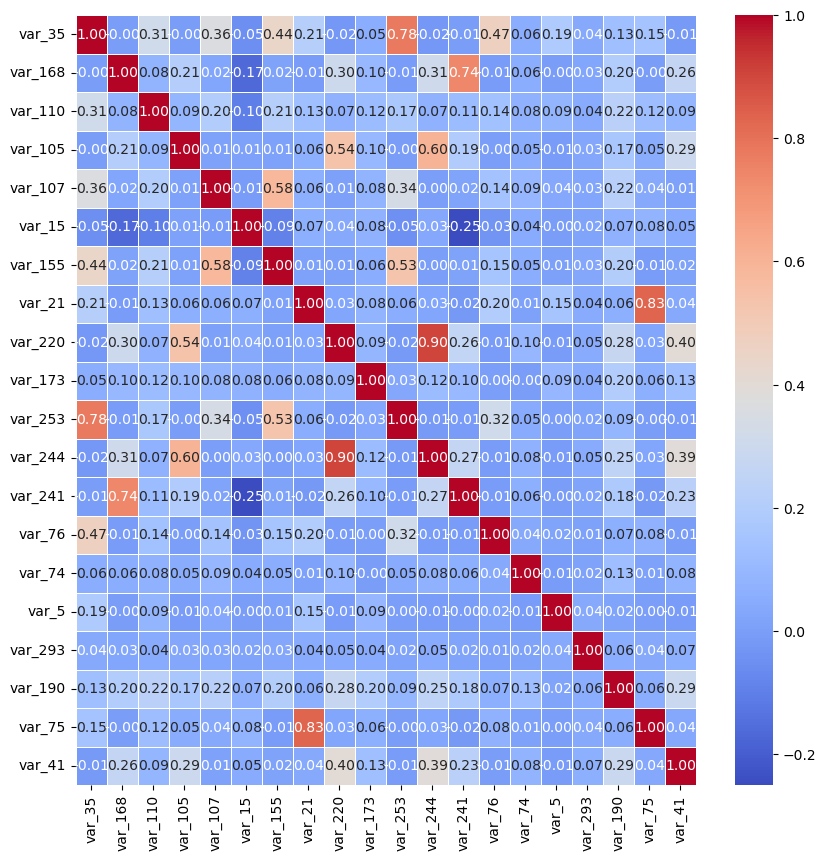

In [7]:
# selected_features = ['var_21', 'var_35', 'var_46', 'var_49', 'var_55', 'var_76', 'var_107', 'var_110', 'var_168', 'var_231']
xcorr = X_train[selected_features].corr()
xcorr
plt.figure(figsize=(10,10))
sns.heatmap(xcorr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5);

# Solidad's solution

In [8]:
# Load your dataset (replace with your dataset)
data = pd.read_csv('../Data/dataset_1.csv')
X = data.drop(labels=['target'], axis=1)
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# we stack all the selection methods inside a pipeline
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
    # ('correlation', SmartCorrelatedSelection(selection_method='variance')),
    ('correlation', SmartCorrelatedSelection(method='pearson', threshold=0.8)),
])

pipe.fit(X_train)

Pipeline(steps=[('constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures()),
                ('correlation', SmartCorrelatedSelection())])

In [9]:
# remove features

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

((40000, 77), (10000, 77))

In [10]:
selected_features = X_train.columns
xgb_model = XGBClassifier(booster='gbtree',objective='binary:logistic', random_state=44, n_jobs=-1)
xgb_model.fit(X_train[selected_features], y_train)

auc_train = roc_auc_score(y_train, xgb_model.predict_proba(X_train[selected_features])[:,1])
auc_test = roc_auc_score(y_test, xgb_model.predict_proba(X_test[selected_features])[:,1])
print(f"AUROC (X_train) with selected features: {auc_train:.4f}")
print(f"AUROC (X_test) with selected features: {auc_test:.4f}")

AUROC (X_train) with selected features: 0.9599
AUROC (X_test) with selected features: 0.8228


In [11]:
feature_dict = dict(zip(X_train.columns, xgb_model.feature_importances_))
df_features = pd.DataFrame.from_dict(feature_dict, orient='index', columns=['Importance'])
df_features = df_features.sort_values(by='Importance', ascending=False)
selected_features = df_features.index[:20].tolist()
df_features.head()

,Importance
var_35,0.064070
var_152,0.049645
var_5,0.049195
var_110,0.049088
var_230,0.028067


In [12]:
xgb_model = XGBClassifier(booster='gbtree',objective='binary:logistic', random_state=44, n_jobs=-1)
xgb_model.fit(X_train[selected_features], y_train)

auc_train = roc_auc_score(y_train, xgb_model.predict_proba(X_train[selected_features])[:,1])
auc_test = roc_auc_score(y_test, xgb_model.predict_proba(X_test[selected_features])[:,1])
print(f"AUROC (X_train) with selected features: {auc_train:.4f}")
print(f"AUROC (X_test) with selected features: {auc_test:.4f}")

AUROC (X_train) with selected features: 0.9547
AUROC (X_test) with selected features: 0.8194


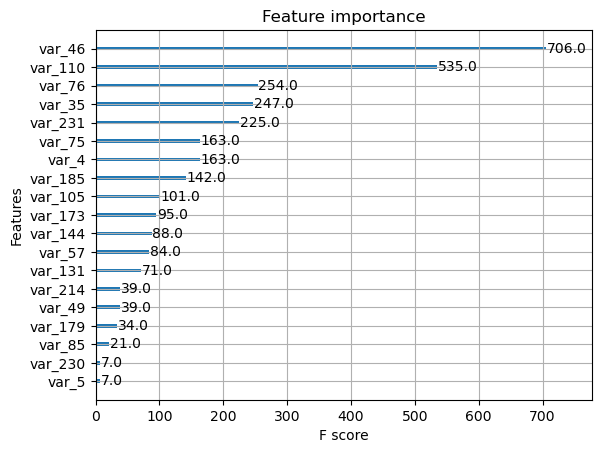

In [13]:
# Plot feature importance
plot_importance(xgb_model)
plt.show()

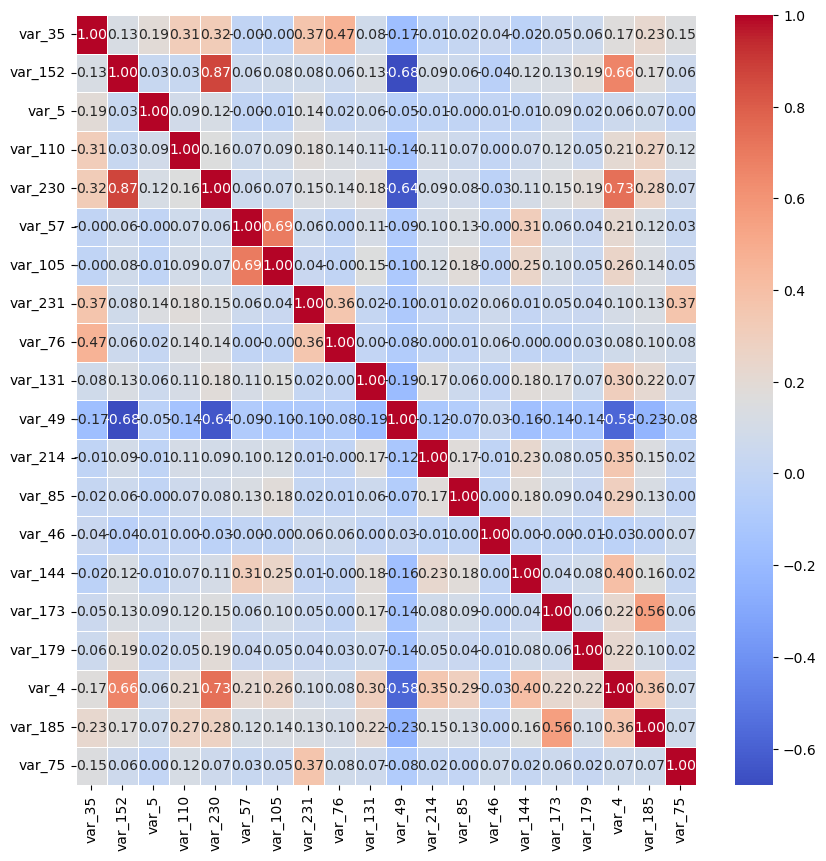

In [14]:
xcorr = X_train[selected_features].corr()
xcorr
plt.figure(figsize=(10,10))
sns.heatmap(xcorr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5);

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Load your dataset (replace with your dataset)
data = pd.read_csv('../Data/dataset_1.csv')
X = data.drop(labels=['target'], axis=1)
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# we stack all the selection methods inside a pipeline
# random forest
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=20,
    n_jobs=4,
)

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
    # ('correlation', SmartCorrelatedSelection(selection_method='variance')),
    ('correlation', SmartCorrelatedSelection(variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.8,
    missing_values="raise",
    selection_method="model_performance",
    estimator=rf,
    scoring="roc_auc",
    cv=3,)),
])

pipe.fit(X_train, y_train)

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.8/multiprocessing/resource_tracker.py:96: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

/Users/oliverdreger/opt/anaconda3/envs/ml2023/lib/python3.8/multiprocessing/resource_tracker.py:96: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

/Users/oliverdreger/opt/ana

Pipeline(steps=[('constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures()),
                ('correlation',
                 SmartCorrelatedSelection(estimator=RandomForestClassifier(n_estimators=10,
                                                                           n_jobs=4,
                                                                           random_state=20),
                                          missing_values='raise',
                                          selection_method='model_performance'))])

In [18]:
# remove features

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

ValueError: The number of columns in this dataset is different from the one used to fit this transformer (when using the fit() method).

In [19]:
selected_features = X_train.columns
xgb_model = XGBClassifier(booster='gbtree',objective='binary:logistic', random_state=44, n_jobs=-1)
xgb_model.fit(X_train[selected_features], y_train)

auc_train = roc_auc_score(y_train, xgb_model.predict_proba(X_train[selected_features])[:,1])
auc_test = roc_auc_score(y_test, xgb_model.predict_proba(X_test[selected_features])[:,1])
print(f"AUROC (X_train) with selected features: {auc_train:.4f}")
print(f"AUROC (X_test) with selected features: {auc_test:.4f}")

AUROC (X_train) with selected features: 0.9564
AUROC (X_test) with selected features: 0.8225


In [20]:
feature_dict = dict(zip(X_train.columns, xgb_model.feature_importances_))
df_features = pd.DataFrame.from_dict(feature_dict, orient='index', columns=['Importance'])
df_features = df_features.sort_values(by='Importance', ascending=False)
selected_features = df_features.index[:20].tolist()
df_features.head()

,Importance
var_168,0.089232
var_35,0.072383
var_110,0.045599
var_103,0.025039
var_57,0.023695


In [21]:
xgb_model = XGBClassifier(booster='gbtree',objective='binary:logistic', random_state=44, n_jobs=-1)
xgb_model.fit(X_train[selected_features], y_train)

auc_train = roc_auc_score(y_train, xgb_model.predict_proba(X_train[selected_features])[:,1])
auc_test = roc_auc_score(y_test, xgb_model.predict_proba(X_test[selected_features])[:,1])
print(f"AUROC (X_train) with selected features: {auc_train:.4f}")
print(f"AUROC (X_test) with selected features: {auc_test:.4f}")

AUROC (X_train) with selected features: 0.9524
AUROC (X_test) with selected features: 0.8211


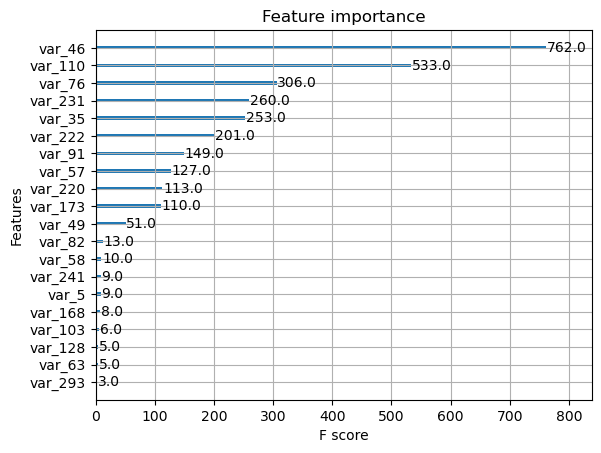

In [22]:
# Plot feature importance
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

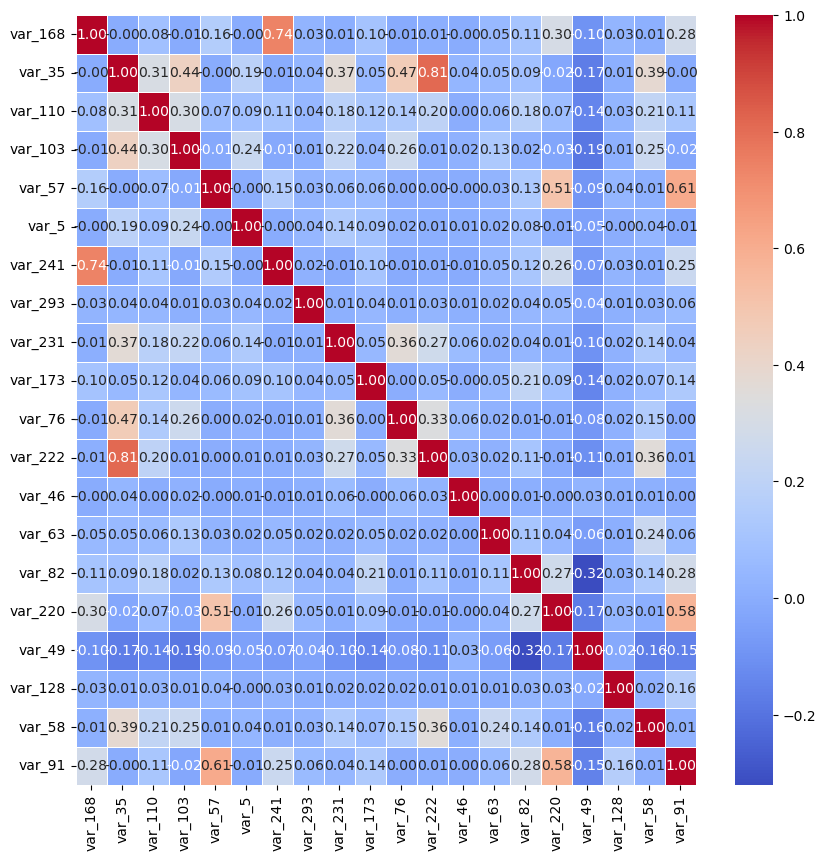

In [23]:
xcorr = X_train[selected_features].corr()
xcorr
plt.figure(figsize=(10,10))
sns.heatmap(xcorr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5);

In [24]:
import shap

In [25]:
xgb_model.predict_proba(X_train[selected_features])[:,1][1]

0.022480335

Probability: 0.07972636818885803


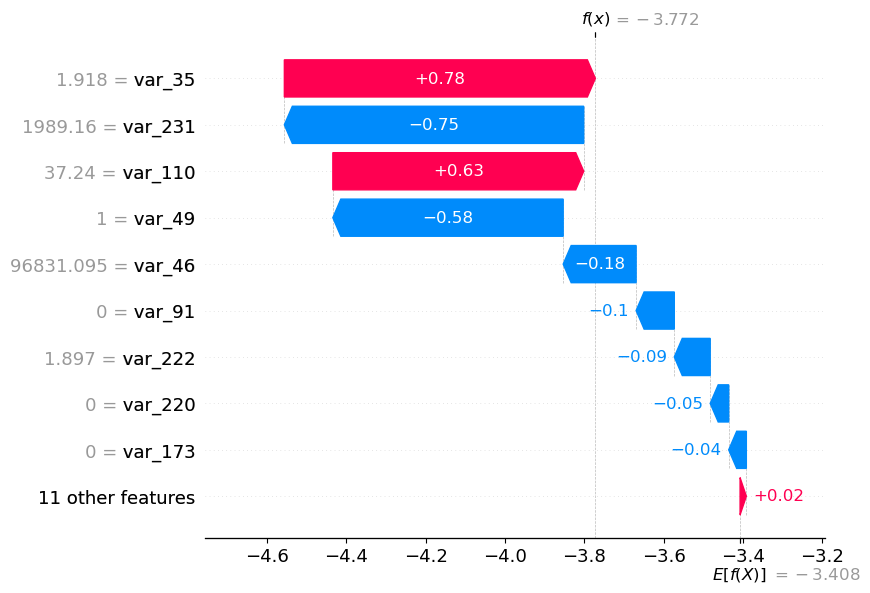

In [26]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train[selected_features])

# visualize the first prediction's explanation
print(f"Probability: {xgb_model.predict_proba(X_train[selected_features])[:,1][0]}")
shap.plots.waterfall(shap_values[1])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [83]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

In [85]:
# visualize all the training set predictions
shap.plots.force(shap_values[:500])

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


Yes, you can include your own functions in a scikit-learn pipeline by using the FunctionTransformer class. This allows you to apply a function to the data within the pipeline. Here's a basic example:

In [26]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Sample function to be included in the pipeline
def custom_function(X):
    # Example: Apply a custom transformation to the data
    return np.log1p(X)

# Sample data
X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# Create a pipeline with a custom function
pipeline = Pipeline([
    ('custom_transform', FunctionTransformer(custom_function)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

# Fit and transform the data using the pipeline
X_transformed = pipeline.fit_transform(X)

# Display the transformed data
print(X_transformed)


[[ 2.28316745 -0.02058136]
 [-0.37481813  0.0562539 ]
 [-1.90834932 -0.03567254]]


In [51]:
mydict = {
    'age':[22, 30, 26, 53, 85],
    'income':[100, 120, 230, 501, 50]
}
df_try = pd.DataFrame.from_dict(mydict)
df_try

,age,income
0,22,100
1,30,120
2,26,230
3,53,501
4,85,50


In [54]:
import utils
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('increase', FunctionTransformer(utils.increase)),
    ('scaler', MinMaxScaler((0,1))),
    # ('scaler', StandardScaler()), 
])

df_try_transformed = pipeline.fit_transform(df_try)
df_try_transformed

array([[0.        , 0.11086475],
       [0.12698413, 0.15521064],
       [0.06349206, 0.39911308],
       [0.49206349, 1.        ],
       [1.        , 0.        ]])

In [57]:
pd.DataFrame(df_try_transformed, columns=['age', 'income'])

,age,income
0,0.000000,0.110865
1,0.126984,0.155211
2,0.063492,0.399113
3,0.492063,1.000000
4,1.000000,0.000000


In [56]:
df_try

,age,income
0,23,110.0
1,31,132.0
2,27,253.0
3,54,551.1
4,86,55.0


In [48]:
df_try['age_scaled'] = [(i-np.mean(df_try['age'])) / np.std(df_try['age']) for i in df_try['age']]
df_try['income_scaled'] = [(i-np.mean(df_try['income'])) / np.std(df_try['income']) for i in df_try['income']]
df_try

,age,income,age_scaled,income_scaled
0,23,110.0,-0.901875,-0.620458
1,31,132.0,-0.561545,-0.496614
2,27,253.0,-0.731710,0.184528
3,54,551.1,0.416904,1.862613
4,86,55.0,1.778224,-0.930068
